### Analysis of game and reward + prediction


#### Import


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import HTML, display

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split as tts 
from tensorflow.keras.losses import mse, mean_absolute_error
from tensorflow.keras.optimizers import RMSprop, Adadelta


/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
tf.__version__

'1.14.0'

In [3]:
def build_formula(target, cols):
    
    f = target + " ~ "
    f += " + ".join(map(lambda x: "C(" + x +")" , cols))
    
    return f


def compute_pseudo_r_squared(mod):
    return 1 - mod.deviance/mod.null_deviance

In [2]:
data = pd.read_csv('data/hands_and_reward.csv')
data = data.drop("Unnamed: 0", axis=1)


suit = ["atout", "na_1", "na_2", "na_3"]
cards = ["7", "8", "9", "10", "jack", "queen", "king", "as"]
players = ["p1", "p2"]
data.columns = [(suit*2)[x//8]+"_"+cards[x%8]+"_"+players[x//32] for x in range(64)] + ["total_reward"]

In [4]:
data.head()

,atout_7_p1,atout_8_p1,atout_9_p1,atout_10_p1,atout_jack_p1,atout_queen_p1,atout_king_p1,atout_as_p1,na_1_7_p1,na_1_8_p1,...,na_2_as_p2,na_3_7_p2,na_3_8_p2,na_3_9_p2,na_3_10_p2,na_3_jack_p2,na_3_queen_p2,na_3_king_p2,na_3_as_p2,total_reward
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,70.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,51.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,74.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,44.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,78.0


### Build formula

In [5]:
formula = build_formula("total_reward", cols = np.concatenate([data.columns[:-1]]).tolist())
formula

'total_reward ~ C(atout_7_p1) + C(atout_8_p1) + C(atout_9_p1) + C(atout_10_p1) + C(atout_jack_p1) + C(atout_queen_p1) + C(atout_king_p1) + C(atout_as_p1) + C(na_1_7_p1) + C(na_1_8_p1) + C(na_1_9_p1) + C(na_1_10_p1) + C(na_1_jack_p1) + C(na_1_queen_p1) + C(na_1_king_p1) + C(na_1_as_p1) + C(na_2_7_p1) + C(na_2_8_p1) + C(na_2_9_p1) + C(na_2_10_p1) + C(na_2_jack_p1) + C(na_2_queen_p1) + C(na_2_king_p1) + C(na_2_as_p1) + C(na_3_7_p1) + C(na_3_8_p1) + C(na_3_9_p1) + C(na_3_10_p1) + C(na_3_jack_p1) + C(na_3_queen_p1) + C(na_3_king_p1) + C(na_3_as_p1) + C(atout_7_p2) + C(atout_8_p2) + C(atout_9_p2) + C(atout_10_p2) + C(atout_jack_p2) + C(atout_queen_p2) + C(atout_king_p2) + C(atout_as_p2) + C(na_1_7_p2) + C(na_1_8_p2) + C(na_1_9_p2) + C(na_1_10_p2) + C(na_1_jack_p2) + C(na_1_queen_p2) + C(na_1_king_p2) + C(na_1_as_p2) + C(na_2_7_p2) + C(na_2_8_p2) + C(na_2_9_p2) + C(na_2_10_p2) + C(na_2_jack_p2) + C(na_2_queen_p2) + C(na_2_king_p2) + C(na_2_as_p2) + C(na_3_7_p2) + C(na_3_8_p2) + C(na_3_9_p2) +

In [6]:
mod = smf.glm(formula=formula, data=data.loc[:80000], family=sm.families.Gaussian()).fit()
print("pseudo_R2: ", compute_pseudo_r_squared(mod))

pseudo_R2:  0.39622837367385766


In [54]:
HTML(
(mod.summary()
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

/anaconda/lib/python3.6/site-packages/statsmodels/sandbox/regression/predstd.py:97: RuntimeWarning: invalid value encountered in sqrt
  predstd = np.sqrt(predvar)


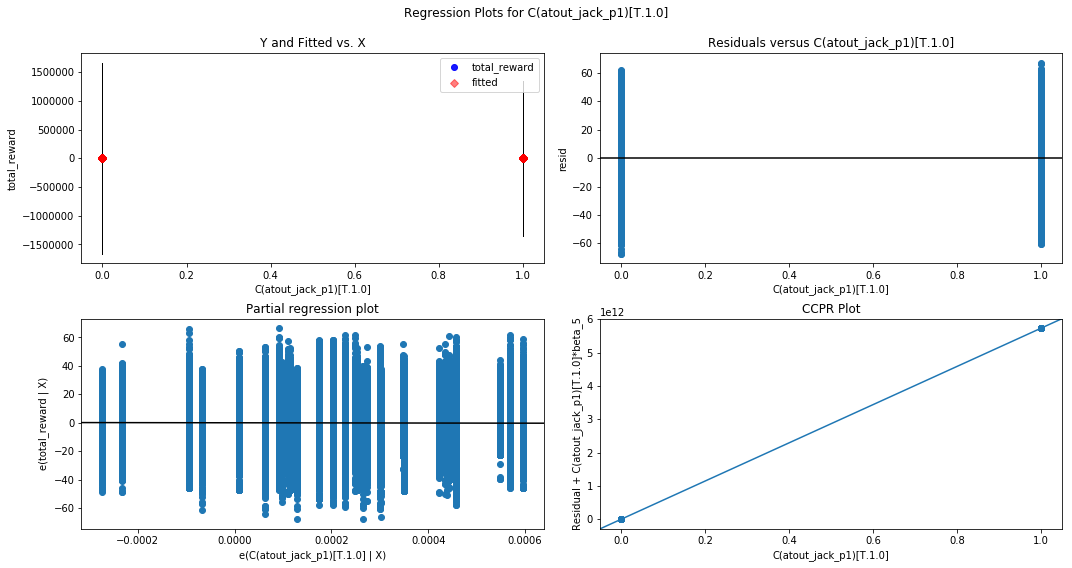

In [34]:
fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(mod, "C(atout_jack_p1)[T.1.0]", fig=fig)
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
mean_squared_error(data.loc[:80000].total_reward, mod.predict(data.loc[:80000]))

287.9896655640394

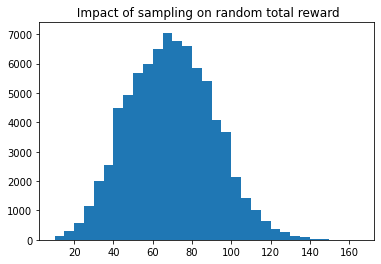

In [6]:
plt.hist(data.loc[:80000]["total_reward"], bins=np.arange(10, 170, 5), label="3 random + 1 AI")
# plt.hist(mod.predict(data.loc[:80000]), bins=np.arange(10, 170, 5), label="3 random + 1 AI")


# # # To run if you created hands_and_reward_full_ai.csv that is obtained using 4 AIPlayers int env.py
# # plt.hist(data_full_ai["64"],  bins= np.arange(10, 170, 5), label="4 AI")
plt.title(" Impact of sampling on random total reward")
# plt.legend()
plt.show()

### First neural network model with convolutions taking two players games

In [205]:
# Creatgin class_weigth dict to penalize extreme values
# thresholds = [30, 50, 80, 100, 110]
class_weights = {}
for i in range(163):
    i = float(i)
    if i > 110:
        class_weights[i] = 4
    elif (i <= 50) | (i > 100):
        class_weights[i] = 3
    elif (i > 82) | (i <60):
        class_weights[i] = 2
    else:
        class_weights[i] = 1

In [229]:
def build_complementary_games(x,y):
    return 1-x, 162-y

def build_cnn_model():
    model = models.Sequential()
    
    model.add(layers.Conv1D(filters=16, kernel_size=4, activation='relu', input_shape=(64, 1)))
    model.add(layers.AveragePooling1D(pool_size = 4, strides=4))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=8, kernel_size=4, activation='relu'))
    model.add(layers.AveragePooling1D(pool_size = 4))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(filters=4, kernel_size=2, activation='relu'))
    model.add(layers.AveragePooling1D(pool_size = 2))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    return model

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=64))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    return model

model = build_cnn_model()
optimizer = RMSprop
loss = mse
model.compile(optimizer="adam", loss=loss)

model_class_weight = build_cnn_model()
optimizer = RMSprop
loss = mse
model_class_weight.compile(optimizer="adam", loss=loss)

relu_model = build_model()
optimizer = RMSprop
loss = mse
relu_model.compile(optimizer="adam", loss=loss)

In [244]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(64,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    return model


relu_class_weigth_model = build_model()
optimizer = RMSprop
loss = mse
relu_class_weigth_model.compile(optimizer="adam", loss=loss)


relu_model = build_model()
optimizer = RMSprop
loss = mse
relu_model.compile(optimizer="adam", loss=loss)

In [223]:
xtrain, xtest, ytrain, ytest = tts(data[data.columns[:-1]].values, data.total_reward, test_size=0.2, random_state=4)
xtrain = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
xtest = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

In [192]:
from sklearn.preprocessing import StandardScaler

stsc = StandardScaler()
stsc.fit(ytrain.values.reshape(-1,1))
ytrain_scaled = stsc.transform(ytrain.values.reshape(-1,1))
ytest_scaled = stsc.transform(ytest.values.reshape(-1,1))

In [276]:
epochs = 50

model.fit(x = xtrain, y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest, ytest))

model_class_weight.fit(x = xtrain, y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest, ytest), class_weight=class_weights)

relu_model.fit(x = xtrain.reshape(80000, 64), y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest.reshape(20000, 64), ytest))

relu_class_weigth_model.fit(x = xtrain.reshape(80000, 64), y = ytrain, epochs=epochs, batch_size=256, 
          validation_data=(xtest.reshape(20000, 64), ytest), class_weight=class_weights)

Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 5s 64us/sample - loss: 290.4362 - val_loss: 288.3045
Epoch 2/50
80000/80000 [==============================] - 4s 54us/sample - loss: 290.2066 - val_loss: 292.8114
Epoch 3/50
80000/80000 [==============================] - 4s 56us/sample - loss: 289.8010 - val_loss: 289.4200
Epoch 4/50
80000/80000 [==============================] - 5s 57us/sample - loss: 289.9734 - val_loss: 287.7491
Epoch 5/50
80000/80000 [==============================] - 5s 56us/sample - loss: 290.0158 - val_loss: 290.3205
Epoch 6/50
80000/80000 [==============================] - 4s 54us/sample - loss: 289.7099 - val_loss: 288.3926
Epoch 7/50
80000/80000 [==============================] - 4s 55us/sample - loss: 289.6095 - val_loss: 287.5789
Epoch 8/50
80000/80000 [==============================] - 4s 55us/sample - loss: 289.4792 - val_loss: 287.1609
Epoch 9/50
80000/80000 [==============================] - 5s 6

Epoch 46/50
80000/80000 [==============================] - 2s 22us/sample - loss: 288.1474 - val_loss: 286.6354
Epoch 47/50
80000/80000 [==============================] - 2s 22us/sample - loss: 287.7901 - val_loss: 288.7692
Epoch 48/50
80000/80000 [==============================] - 2s 23us/sample - loss: 288.0357 - val_loss: 287.0754
Epoch 49/50
80000/80000 [==============================] - 2s 22us/sample - loss: 287.9863 - val_loss: 289.5437
Epoch 50/50
80000/80000 [==============================] - 2s 23us/sample - loss: 287.8044 - val_loss: 287.6174
Train on 80000 samples, validate on 20000 samples
Epoch 1/50
80000/80000 [==============================] - 7s 91us/sample - loss: 665.4782 - val_loss: 304.6307
Epoch 2/50
80000/80000 [==============================] - 2s 24us/sample - loss: 665.2566 - val_loss: 311.2241
Epoch 3/50
80000/80000 [==============================] - 2s 23us/sample - loss: 665.9528 - val_loss: 304.1785
Epoch 4/50
80000/80000 [==============================] -

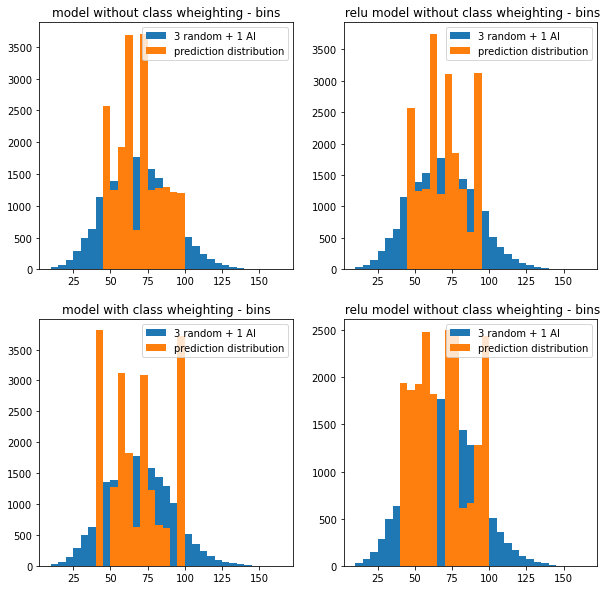

In [279]:
x1 = sorted(np.absolute(ytest-model_class_weight.predict(xtest).reshape(ytest.shape)))
x2 = sorted(np.absolute(ytest-model.predict(xtest).reshape(ytest.shape)))
x3 = sorted(np.absolute(ytest-relu_class_weigth_model.predict(xtest.reshape(20000, 64)).reshape(ytest.shape)))
x4 = sorted(np.absolute(ytest-relu_model.predict(xtest.reshape(20000, 64)).reshape(ytest.shape)))

plt.figure(figsize = (10, 10))
plt.subplot(2,2,1)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(model.predict(xtest), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title("model without class wheighting - bins")
plt.legend()

plt.subplot(2,2,2)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(relu_model.predict(xtest.reshape(20000, 64)), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title(" relu model without class wheighting - bins")
plt.legend()

plt.subplot(2,2,3)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(model_class_weight.predict(xtest), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title("model with class wheighting - bins")
plt.legend()

plt.subplot(2,2,4)
plt.hist(ytest, bins=np.arange(10, 170, 5), label="3 random + 1 AI")
plt.hist(relu_class_weigth_model.predict(xtest.reshape(20000, 64)), bins=np.arange(10, 170, 5), label="prediction distribution")
plt.title(" relu model with class wheighting - bins")
plt.legend()
plt.show()

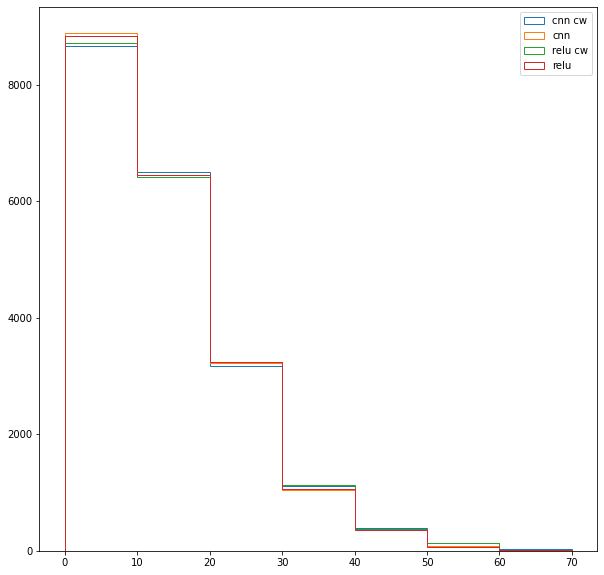

In [282]:
kwargs = dict(histtype='step', bins=np.arange(0, 80, 10))

plt.figure(figsize=(10,10))
plt.hist(x1, label = "cnn cw", **kwargs)
plt.hist(x2,label = "cnn", **kwargs)
plt.hist(x3,label = "relu cw", **kwargs)
plt.hist(x4,label = "relu", **kwargs)
plt.legend()
plt.show()



### Explenation using Lime

In [133]:
import lime
import lime.lime_tabular

In [139]:
data

,atout_7_p1,atout_8_p1,atout_9_p1,atout_10_p1,atout_jack_p1,atout_queen_p1,atout_king_p1,atout_as_p1,na_1_7_p1,na_1_8_p1,...,na_2_as_p2,na_3_7_p2,na_3_8_p2,na_3_9_p2,na_3_10_p2,na_3_jack_p2,na_3_queen_p2,na_3_king_p2,na_3_as_p2,total_reward
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,70.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,51.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,74.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,44.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,58.0
99996,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,86.0
99997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
99998,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,49.0


In [150]:
explainer = lime.lime_tabular.LimeTabularExplainer(ytrain, 
                                                   
                                                   class_names=['total_reward'])

IndexError: tuple index out of range

In [135]:
data.loc[:10]

,atout_7_p1,atout_8_p1,atout_9_p1,atout_10_p1,atout_jack_p1,atout_queen_p1,atout_king_p1,atout_as_p1,na_1_7_p1,na_1_8_p1,...,na_2_as_p2,na_3_7_p2,na_3_8_p2,na_3_9_p2,na_3_10_p2,na_3_jack_p2,na_3_queen_p2,na_3_king_p2,na_3_as_p2,total_reward
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,70.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,51.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,74.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,44.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,78.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,70.0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,67.0
7,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,93.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,53.0


In [ ]:
exp.show_in_notebook(show_table=True)